In [1]:
# TODO: verify stance (force map looks like the problem)
# TODO: implement refresh rate for different controllers
# TODO: implement sensor noise
# TODO: implement impact detection
# TODO: implement smarter gait scheduler (support polygon?)

In [2]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time as t
import itertools
import numpy as np
import random
from scipy import optimize as opt

import leg_controller as con
import gait_scheduler as gs
import pd_controller as pd

from tqdm.auto import tqdm

/home/jack/SynologyDrive/Documents/School/Thesis/Thesis/MS-Thesis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model and create MjData and Renderer objects to go along with it

$\texttt{model}$ contains all information about the robot/environment; this includes all parts, links, joints, and the ground.

$\texttt{data}$ contains all information about the state of $\texttt{model}$. We can read information about the environment's state here, and apply forces at joints. This is where all the physics modeling takes place.

$\texttt{renderer}$ contains all necessary information to render the scene.

In [3]:
# simulation environment
model = mujoco.MjModel.from_binary_path("Quadruped MJB.mjb")
data = mujoco.MjData(model)

# visualization
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
camera.type = 1
camera.distance = 1.5
camera.trackbodyid = 2
# side view
if True:
    camera.azimuth = 0  # horizontal camera panning
    camera.elevation = -2  # camera height off the ground
# isometric view
if False:
    camera.azimuth = 30

# model configuration
model.opt.gravity = (0, 0, -9.81)  # set simulation gravity
model.opt.integrator = 3  # select integrator (0 = Euler, 1 = implicitfast, 2 = implicit, 3 = rk4)
model.opt.timestep = .0005  # set timestep

# create the controller objects
fr_leg = con.leg_controller('Front Right')
fl_leg = con.leg_controller('Front Left')
rr_leg = con.leg_controller('Rear Right')
rl_leg = con.leg_controller('Rear Left')
legs = (fr_leg, fl_leg, rr_leg, rl_leg)
gait_scheduler = gs.gait_scheduler(legs)
pd_controller = pd.PD()

## Define functions for running the robot's controllers

$\texttt{model\_to\_abs()}$ accounts for zero offsets and incorrect axis directions, and $\texttt{abs\_to\_model()}$ does the reverse conversion. These functions are necessary because the .mjb file for the robot does not have the joints zeroed in the correct place; ideally this would be fixed in the model, but due to the poor performance of the Solidworks to URDF extension, this option is preferred.

In [4]:
def model_to_abs(mod_pos):
    pos_offsets = np.array([
        .736600934, -1.51121634, .737159549, -1.51177616, .736600879,
        -1.51121629, .737164507, -1.51177608
    ])

    abs_pos = mod_pos - pos_offsets
    return abs_pos


def abs_to_model(abs_pos):
    pos_offsets = np.array([
        .736600934, -1.51121634, .737159549, -1.51177616, .736600879,
        -1.51121629, .737164507, -1.51177608
    ])

    mod_pos = abs_pos + pos_offsets
    return mod_pos

# Estimate the state
This function performs all the state estimation the robot needs to operate.

$$ \texttt{data.qpos} = [x, y, z , pitch , roll , yaw , fr\_hip , fr\_knee , fl\_hip , fl\_knee , rr\_hip , rr\_knee , rl\_hip , rl\_knee] $$

$$ \texttt{data.qvel} = [\dot{x}, \dot{y}, \dot{z} , \dot{pitch} , \dot{roll} , \dot{yaw} , \dot{fr\_hip} , \dot{fr\_knee} , \dot{fl\_hip} , \dot{fl\_knee} , \dot{rr\_hip} , \dot{rr\_knee} , \dot{rl\_hip} , \dot{rl\_knee}] $$

In [5]:
def state_estimation(model, data):
    # get 'sensor data' (add noise if needed)
    curr_pos = data.qpos  # + np.random.rand(14)*.01
    curr_pos = np.concatenate((curr_pos[1:7], model_to_abs(curr_pos[7:15])))
    curr_vel = data.qvel  # + np.random.rand(14)*.01
    curr_forces = data.qfrc_inverse[6:]  # + np.random.rand(14)*.01

    # do stuff for each leg
    i = 0
    window_len = 100
    for leg in legs:
        # update the leg's current position
        leg.curr_pos = curr_pos[6 + 2 * i:8 + 2 * i]
        # update the leg's current velocity
        leg.curr_vel = curr_vel[6 + 2 * i:8 + 2 * i]
        #print(leg.curr_pos)
        # update the body attitude
        leg.pitch = curr_pos[3]
        leg.roll = curr_pos[4]
        leg.yaw = curr_pos[5]
        # update the body velocity
        leg.pitch_vel = curr_vel[3]
        leg.roll_vel = curr_vel[4]
        leg.yaw_vel = curr_vel[5]
        # update the moving average leg forces
        leg.avg_force[0] = (
            leg.avg_force[0] *
            (window_len - 1)) / window_len + curr_forces[2 * i] / window_len
        leg.avg_force[1] = (leg.avg_force[1] *
                            (window_len - 1)) / window_len + curr_forces[
                                2 * i + 1] / window_len
        # update the leg force
        leg.curr_force = curr_forces[2 * i:2 * i + 2]
        # resolve the contact state
        leg.detect_contact()
        leg.detect_liftoff()
        # increment the counter
        i = i + 1


state_estimation(model, data)

# Run the controller
This function runs each of the controllers as well as handling the passing of information/commands between controllers

$ \texttt{data.actuator} = ['kd\ fl\ hip', 'kd\ fl\ knee', 'kd\ fr\ hip', 'kd\ fr\ knee', 'kd\ rl\ hip', 'kd\ rl\ knee', 'kd\ rr\ hip', 'kd\ rr\ knee', 'kp\ fl\ hip', 'kp\ fl\ knee', 'kp\ fr\ hip', 'kp\ fr\ knee', 'kp\ rl\ hip', 'kp\ rl\ knee', 'kp\ rr\ hip', 'kp\ rr\ knee']$

In [6]:
def update_controller(model, data):
    # assign memory
    desired = np.zeros(8)
    actual = np.zeros(8)

    # run gait scheduling layer
    gait_scheduler.time = data.time
    gait_scheduler.fixed_time_bound(fr_leg, fl_leg, rr_leg, rl_leg)

    # run leg control layer
    i = 0
    for leg in legs:
        desired[2 * i:2 * i + 2] = leg.run_controller(data.time)
        #print(leg.curr_pos)
        i = i + 1

    # run PD layer
    curr_vel = data.qvel[6:14]
    i = 0
    # choose the correct feedback variable
    for leg in legs:
        # position control
        if leg.control_type == 0:
            # the actual position is the current position with offsets applied (offests are applied after for loop)
            actual[2 * i] = leg.curr_pos[0]
            actual[2 * i + 1] = leg.curr_pos[1]
            # the desired position is the controller output with the offsets applied (offsets are applied after for loop)
            desired[2 * i] = desired[2 * i]
            desired[2 * i + 1] = desired[2 * i + 1]
        # force control
        elif leg.control_type == 1:
            # the actual force is the current force
            actual[2 * i] = leg.curr_force[0]
            actual[2 * i + 1] = leg.curr_force[1]
            if actual[2 * i] > 8 or actual[2 * i + 1] > 8:
                pass#print('Saturating!')
            # the desired force is the controller output with no offsets applied, so no changes are necessary
        i = i + 1

    i = 0
    for leg in legs:
        data.ctrl[2 * i:2 * i + 2] = pd_controller.run_pd(
            leg, desired[2 * i:2 * i + 2], actual[2 * i:2 * i + 2],
            curr_vel[2 * i:2 * i + 2])
        i = i + 1


update_controller(model, data)

# Simulate, render, and record the behaviour of the system

In [7]:
# initialize the simulation
mujoco.mj_resetData(model, data)

# define parameters of rendering and sim
duration = 2  # (seconds)
framerate = 30  # (Hz)
slomo_factor = 2
n_steps = int(duration / model.opt.timestep + 1)

# allocate memory for arrays
frames = []
positions = np.zeros((n_steps, model.nv))
velocities = np.zeros((n_steps, model.nv))
forces = np.zeros((n_steps, model.nv))
avg_forces = np.zeros((n_steps, model.nv))
contacts = np.zeros((n_steps, 1))
contacts = []
controller_output = np.zeros((n_steps, 2))
control_input = np.zeros((n_steps, 8))
controller_time = np.zeros(n_steps)
states = np.zeros((n_steps, 4))
time = np.zeros(n_steps)
energy = np.zeros((n_steps, 3))

# Simulate and display video.
mujoco.mj_resetData(model, data)  # Reset state and time.
i = 0
for i in tqdm(range(n_steps)):
    # step the simulator
    mujoco.mj_step(model, data)
    mujoco.mj_inverse(model, data)

    # estimate the state
    state_estimation(model, data)

    # apply control
    temp = t.time()
    update_controller(model, data)
    controller_time[i] = t.time() - temp

    # store any data we need stored (lower resolution to save on time)
    positions[i] = np.concatenate(
        (data.qpos[:6], model_to_abs(data.qpos[7:15])))
    velocities[i] = data.qvel
    time[i] = data.time
    forces[i] = data.qfrc_inverse
    avg_forces[i] = np.array(
        np.concatenate(([0], [0], [0], [0], [0], [0], fr_leg.avg_force,
                        fl_leg.avg_force, rr_leg.avg_force, rl_leg.avg_force)))
    contacts.append(data.contact)
    #contacts[i] = np.array(
    #    [fr_leg.contact, fl_leg.contact, rr_leg.contact, rl_leg.contact])
    states[i] = np.array(
        [fl_leg.state, fr_leg.state, rl_leg.state, rr_leg.state])
    control_input[i] = data.ctrl
    energy[i] = [
        data.energy[0], data.energy[1], data.energy[0] + data.energy[1]
    ]
    controller_output[i] = legs[0].run_controller(data.time)

    # render the scene if we're at the correct timestep to have a frame
    if len(frames) < data.time * framerate:
        #camera.azimuth = data.time*75
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate/slomo_factor)
print(data.contact)

 28%|██▊       | 1116/4001 [00:01<00:02, 1128.52it/s]

Transition Position: [0.00070099 0.19909315] Transition length: 0.19909438803005294
Transition Position: [0.0007035  0.19909085] Transition length: 0.19909209618039334
Transition Position: [0.00131101 0.19888923] Transition length: 0.19889355059726968
Transition Position: [0.00131534 0.1988868 ] Transition length: 0.1988911508896609


 39%|███▉      | 1565/4001 [00:01<00:02, 1043.45it/s]

Transition Position: [-0.02656118  0.1653058 ] Transition length: 0.1674261156249328
Transition Position: [-0.02656153  0.16530593] Transition length: 0.1674262959956863
Transition Position: [-0.02635531  0.16503801] Transition length: 0.16712913661656198
Transition Position: [-0.0263548   0.16503689] Transition length: 0.16712794674543716


 44%|████▍     | 1774/4001 [00:01<00:02, 907.17it/s] 

Transition Position: [-0.12257115  0.12105807] Transition length: 0.17227519238505432
Transition Position: [-0.12265864  0.12095453] Transition length: 0.17226474133219302
Transition Position: [-0.0304241   0.16482886] Transition length: 0.16761318693521873
Transition Position: [-0.03042004  0.16482253] Transition length: 0.16760622098923655


 54%|█████▍    | 2180/4001 [00:02<00:01, 993.61it/s]

Transition Position: [-0.03156862  0.16426662] Transition length: 0.1672725372009529
Transition Position: [-0.03282625  0.16400704] Transition length: 0.1672598946108529
Transition Position: [-0.03373584  0.16488944] Transition length: 0.1683051849554201
Transition Position: [-0.03373426  0.16489424] Transition length: 0.16830956907294495


 65%|██████▍   | 2594/4001 [00:02<00:01, 985.10it/s]

Transition Position: [-0.09811928  0.13812   ] Transition length: 0.1694241052676412
Transition Position: [-0.09732564  0.13890979] Transition length: 0.16961193514867454
Transition Position: [-0.03176175  0.16510876] Transition length: 0.1681359908022292
Transition Position: [-0.03175147  0.16510467] Transition length: 0.16813003595756187


 72%|███████▏  | 2892/4001 [00:02<00:01, 889.92it/s]

Transition Position: [-0.03390902  0.16101511] Transition length: 0.164546916435913
Transition Position: [-0.03480637  0.1610659 ] Transition length: 0.16478381951208865
Transition Position: [-0.03418398  0.16500458] Transition length: 0.16850832849233635
Transition Position: [-0.03459895  0.16494103] Transition length: 0.16853079700484624


 82%|████████▏ | 3276/4001 [00:03<00:00, 803.44it/s]

Transition Position: [-0.0345185   0.16481951] Transition length: 0.1683953588578088
Transition Position: [-0.03451798  0.16481945] Transition length: 0.1683951976324298
Transition Position: [-0.02820214  0.16491018] Transition length: 0.16730430132867438
Transition Position: [-0.02820122  0.16490956] Transition length: 0.16730352815427196


 89%|████████▉ | 3572/4001 [00:03<00:00, 775.16it/s]

Transition Position: [-0.13026442  0.11034751] Transition length: 0.17072021450280586
Transition Position: [-0.12966778  0.1110134 ] Transition length: 0.17069770786167293
Transition Position: [-0.03423253  0.16476745] Transition length: 0.16828600309467343
Transition Position: [-0.03424163  0.16475167] Transition length: 0.16827240547698885


 98%|█████████▊| 3905/4001 [00:04<00:00, 813.35it/s]

Transition Position: [-0.08143621  0.14721823] Transition length: 0.16824108339453328
Transition Position: [-0.07845218  0.14867251] Transition length: 0.16810193495657202
Transition Position: [-0.02995603  0.16508634] Transition length: 0.16778218742942883
Transition Position: [-0.02996077  0.16507724] Transition length: 0.167774079237007


100%|██████████| 4001/4001 [00:04<00:00, 906.53it/s]


<_MjContactList
  H: array([], shape=(0, 36), dtype=float64)
  dim: array([], dtype=int32)
  dist: array([], dtype=float64)
  efc_address: array([], dtype=int32)
  elem: array([], shape=(0, 2), dtype=int32)
  exclude: array([], dtype=int32)
  flex: array([], shape=(0, 2), dtype=int32)
  frame: array([], shape=(0, 9), dtype=float64)
  friction: array([], shape=(0, 5), dtype=float64)
  geom: array([], shape=(0, 2), dtype=int32)
  geom1: array([], dtype=int32)
  geom2: array([], dtype=int32)
  includemargin: array([], dtype=float64)
  mu: array([], dtype=float64)
  pos: array([], shape=(0, 3), dtype=float64)
  solimp: array([], shape=(0, 5), dtype=float64)
  solref: array([], shape=(0, 2), dtype=float64)
  solreffriction: array([], shape=(0, 2), dtype=float64)
  vert: array([], shape=(0, 2), dtype=int32)
>


# Interpret the recorded data

### Plot the joint positions

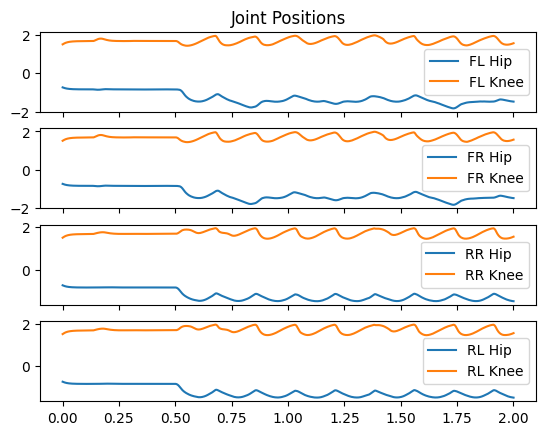

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
ax[0].set_title("Joint Positions")
ax[0].plot(time, np.array(positions[:, 6]), label='FL Hip')
ax[0].plot(time, np.array(positions[:, 7]), label='FL Knee')
ax[1].plot(time, np.array(positions[:, 8]), label='FR Hip')
ax[1].plot(time, np.array(positions[:, 9]), label='FR Knee')
ax[2].plot(time, np.array(positions[:, 10]), label='RR Hip')
ax[2].plot(time, np.array(positions[:, 11]), label='RR Knee')
ax[3].plot(time, np.array(positions[:, 12]), label='RL Hip')
ax[3].plot(time, np.array(positions[:, 13]), label='RL Knee')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

### Plot the contact forces

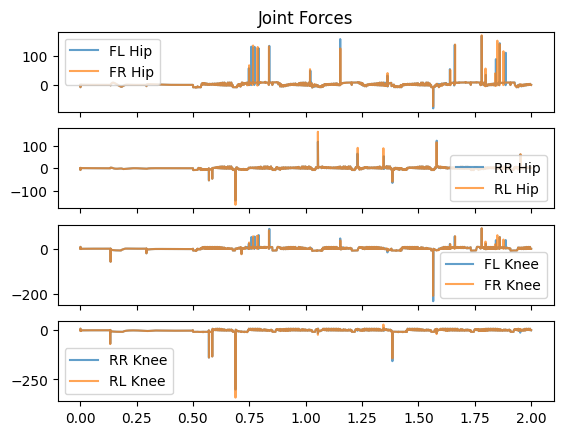

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
ax[0].set_title("Joint Forces")
ax[0].plot(time, np.array(forces[:, 6]), label='FL Hip', alpha=0.7)
ax[0].plot(time, np.array(forces[:, 8]), label='FR Hip', alpha=0.7)
ax[1].plot(time, np.array(forces[:, 10]), label='RR Hip', alpha=0.7)
ax[1].plot(time, np.array(forces[:, 12]), label='RL Hip', alpha=0.7)
ax[2].plot(time, np.array(forces[:, 7]), label='FL Knee', alpha=0.7)
ax[2].plot(time, np.array(forces[:, 9]), label='FR Knee', alpha=0.7)
ax[3].plot(time, np.array(forces[:, 11]), label='RR Knee', alpha=0.7)
ax[3].plot(time, np.array(forces[:, 13]), label='RL Knee', alpha=0.7)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

### Plot the derivative of the contact forces

Text(0.5, 1.0, 'Joint Force Derivatives')

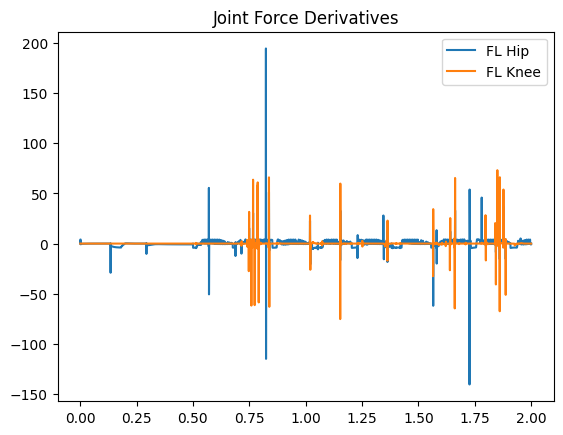

In [10]:
d_forces = np.gradient(forces, 1, axis=1)
plt.plot(time, np.array(d_forces[:, 6]), label='FL Hip')
#plt.plot(time, np.array(d_forces[:, 8]), label='FR Hip')
#plt.plot(time,np.array(d_forces[:,10]),label='RR Hip')
#plt.plot(time,np.array(d_forces[:,12]),label='RL Hip')
plt.plot(time, np.array(d_forces[:, 7]), label='FL Knee')
#plt.plot(time, np.array(d_forces[:, 9]), label='FR Knee')
#plt.plot(time, np.array(d_forces[:, 11]), label='RR Knee')
#plt.plot(time, np.array(d_forces[:, 13]), label='RL Knee')
plt.legend()
plt.title("Joint Force Derivatives")


### Compare the forces with their filtered counterparts

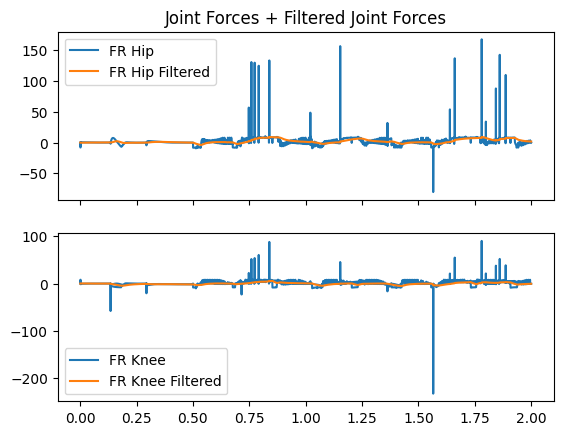

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].set_title("Joint Forces + Filtered Joint Forces")
ax[0].plot(time, np.array(forces[:, 6]), label='FR Hip')
ax[0].plot(time, np.array(avg_forces[:, 6]), label='FR Hip Filtered')
ax[0].fill_between(time, np.array(avg_forces[:, 6]), np.array(avg_forces[:, 6]))
ax[1].plot(time, np.array(forces[:, 7]), label='FR Knee')
ax[1].plot(time, np.array(avg_forces[:, 7]), label='FR Knee Filtered')
ax[1].fill_between(time, np.array(avg_forces[:, 7]), np.array(avg_forces[:, 6]))
ax[0].legend()
ax[1].legend()


### Plot the (estimated) contacts

TypeError: list indices must be integers or slices, not tuple

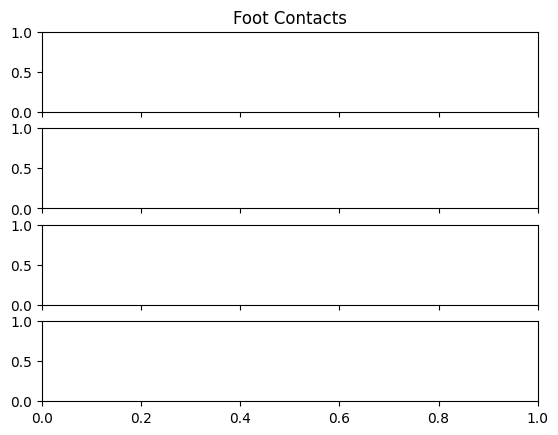

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
ax[0].set_title("Foot Contacts")
ax[0].plot(time, np.array(contacts[:, 0]), label='FL Foot', alpha=0.7)
ax[1].plot(time, np.array(contacts[:, 1]), label='FR Foot', alpha=0.7)
ax[2].plot(time, np.array(contacts[:, 2]), label='RR Foot', alpha=0.7)
ax[3].plot(time, np.array(contacts[:, 3]), label='RL Foot', alpha=0.7)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

### Plot the state of each leg

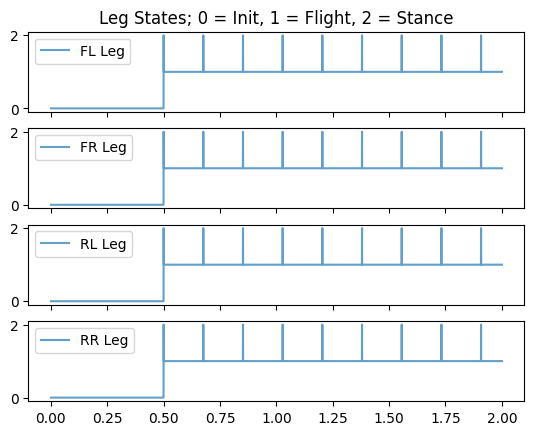

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
ax[0].set_title("Leg States; 0 = Init, 1 = Flight, 2 = Stance")
ax[0].plot(time, states[:, 0], label='FL Leg', alpha=0.7)
ax[1].plot(time, states[:, 1], label='FR Leg', alpha=0.7)
ax[2].plot(time, states[:, 2], label='RL Leg', alpha=0.7)
ax[3].plot(time, states[:, 3], label='RR Leg', alpha=0.7)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

### Compare the joint forces to the leg's state for the FL leg

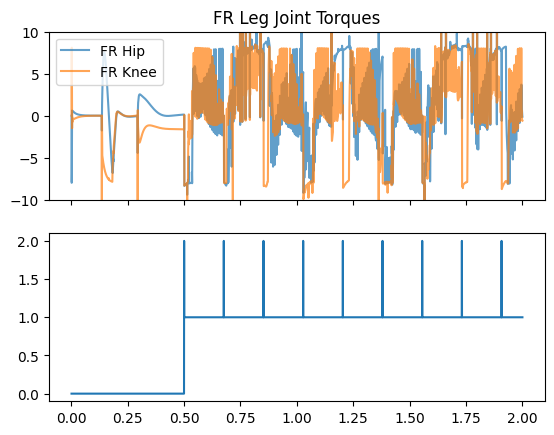

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
# plot the joint torques
ax[0].plot(time, np.array(forces[:, 6]), label='FR Hip', alpha=.7)
ax[0].plot(time, np.array(forces[:, 7]), label='FR Knee', alpha=.7)
ax[0].set_ylim([-10, 10])
ax[0].legend()
ax[0].set_title("FR Leg Joint Torques")
# plot the leg state
ax[1].plot(time, states[:, 1], label='FR Leg')

### Plot the controller outputs and the joint control inputs

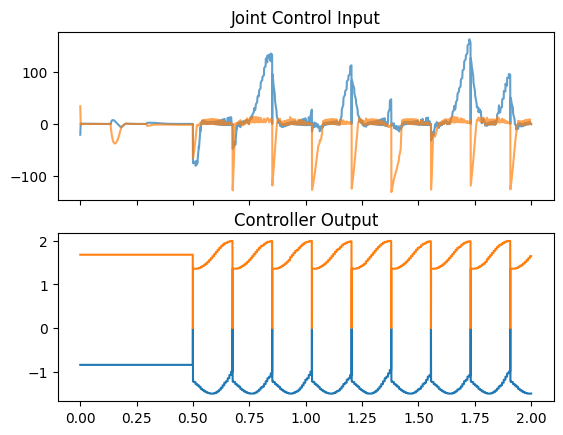

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].title.set_text("Joint Control Input")
ax[0].plot(time, control_input[:, 0], alpha=.7)
ax[0].plot(time, control_input[:, 1], alpha=.7)
#ax[0].plot(time, control_input[:, 2])
#ax[0].plot(time, control_input[:, 3])
#ax[0].plot(time, control_input[:, 4])
#ax[0].plot(time, control_input[:, 5])
#ax[0].plot(time, control_input[:, 6])
#ax[0].plot(time, control_input[:, 7])
ax[1].title.set_text("Controller Output")
ax[1].plot(time, controller_output[:, 0])
ax[1].plot(time, controller_output[:, 1])

### Time the functions

Average controller time: 0.000477107159348316 seconds (2095.96519441441 Hz)
Worst controller time: 0.003968715667724609 seconds (251.97068364772318 Hz)


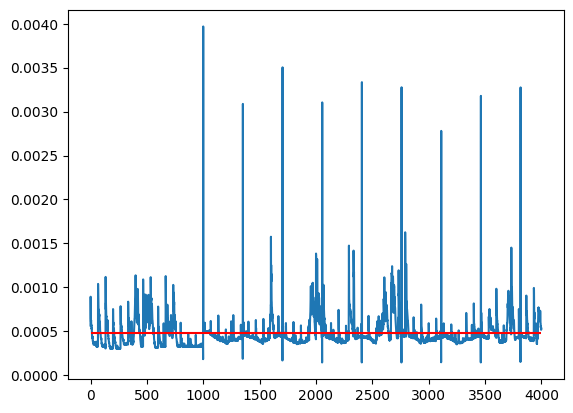

In [ ]:
plt.plot(controller_time)
plt.hlines(np.mean(controller_time), 0, len(controller_time), colors='r')
print(f"Average controller time: {np.mean(controller_time)} seconds ({1/np.mean(controller_time)} Hz)")
print(f"Worst controller time: {np.max(controller_time)} seconds ({1/np.max(controller_time)} Hz)")

### Check energy conservation

Text(0.5, 1.0, 'Energy')

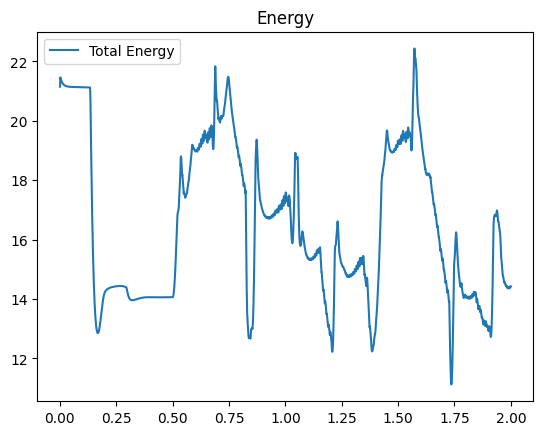

In [ ]:
#plt.plot(time,energy[:,0],label='Potential Energy')
#plt.plot(time,energy[:,1],label='Kinetic Energy')
plt.plot(time, energy[:, 2], label='Total Energy')
plt.legend()
plt.title("Energy")

x: -0.49328775704039945
y: -0.04760470506667043
z: -0.04886444455851625


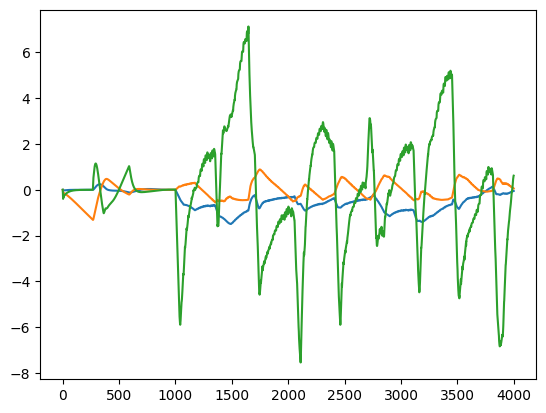

In [ ]:
plt.plot(velocities[:,1])
plt.plot(velocities[:,2])
plt.plot(velocities[:,3])
np.shape(velocities)
print(f"x: {np.mean(velocities[:,1])}")
print(f"y: {np.mean(velocities[:,2])}")
print(f"z: {np.mean(velocities[:,3])}")

# Verify Controller Output
### Flight

Transition Position: [0.         0.21213203] Transition length: 0.21213203435596426
1


/home/jack/SynologyDrive/Documents/School/Thesis/Thesis/MS-Thesis/leg_controller.py:293: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(func=self.f,


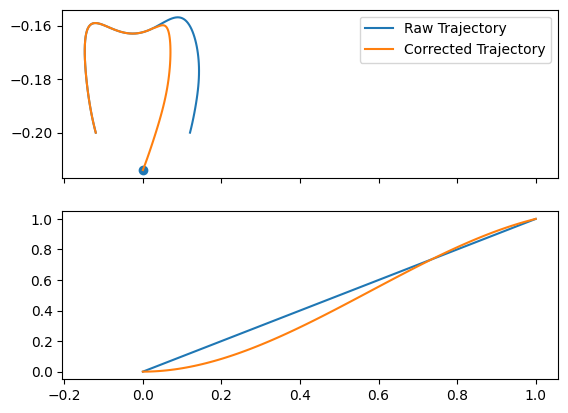

In [ ]:
test_leg = con.leg_controller("Test Leg")
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(test_leg.flight_traj_x,-test_leg.flight_traj_y,label="Raw Trajectory")
test_leg.transition_signal = True
test_leg.run_controller(1)
test_leg.transition_signal = True
test_leg.run_controller(1)

print(test_leg.state)

ax[0].plot(test_leg.flight_traj_x,-test_leg.flight_traj_y,label = "Corrected Trajectory")
ax[0].scatter(test_leg.flight_traj_x[0],-test_leg.flight_traj_y[0])
ax[0].legend()

ax[1].plot(np.linspace(0,1,test_leg.bez_res),np.linspace(0,1,test_leg.bez_res),label="Regular s")
ax[1].plot(np.linspace(0,1,test_leg.bez_res),np.flip(test_leg.flight_traj_idx),label="Phase Warped s")

### Stance

Max x force: 20.86667683699007
Max y force: -20.866676836990067


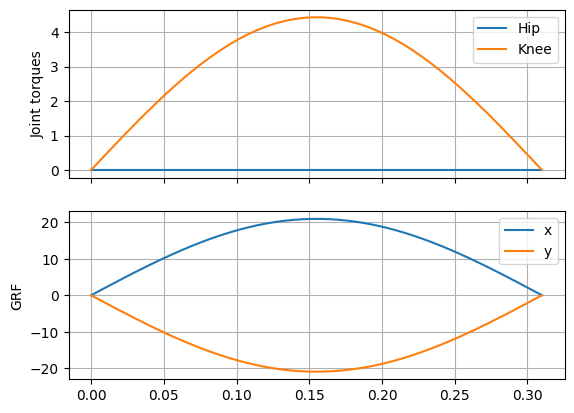

In [ ]:
def torque_to_grf(leg,torques):
    # unpack inputs
    hip_t = torques[0]
    hip_p = leg.curr_pos[0]
    knee_t = torques[1]
    knee_p = leg.curr_pos[1]

    # calculate each actuator's contribution to the torque
    hip_force = [hip_t/leg.l1*np.sin(hip_p) , hip_t/leg.l1*np.cos(hip_p)]
    knee_force = [knee_t/leg.l2*np.sin(hip_p+knee_p),knee_t/leg.l2*np.cos(hip_p+knee_p)]

    # sum the contributions and convert from foot force to grf (just take the negative)
    return -(np.array(hip_force) + np.array(knee_force))

test_leg = con.leg_controller("Test Leg")
test_leg.transition_signal = True
test_leg.run_controller(1)

samples = 50
points = np.linspace(0,test_leg.Tst,samples)
torques = np.zeros([2,samples])
angles = np.zeros_like(torques)
grfs = np.zeros_like(torques)
for i in range(np.size(points)):
    torques[:,i] = test_leg.run_controller(points[i]+1)
    angles[:,i] = test_leg.curr_pos
    grfs[:,i] = torque_to_grf(test_leg,torques[:,i])

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(points,torques[0,:],label="Hip")
ax[0].plot(points,torques[1,:],label="Knee")
ax[0].set_ylabel("Joint torques")
ax[0].grid()
ax[0].legend()
ax[1].plot(points,grfs[0,:],label="x")
ax[1].plot(points,grfs[1,:],label="y")
ax[1].set_ylabel("GRF")
ax[1].grid()
ax[1].legend()

max_hip = max(np.min(torques[0,:]), np.max(torques[0,:]), key=abs)
max_knee = max(np.min(torques[1,:]), np.max(torques[1,:]), key=abs)

fx_max = max(np.min(grfs[0,:]), np.max(grfs[0,:]), key=abs)
fy_max = max(np.min(grfs[1,:]), np.max(grfs[1,:]), key=abs)

print(f"Max x force: {fx_max}")
print(f"Max y force: {fy_max}")